 ## Text Preprocessing

In [1]:
# Operating system utilities (like file/folder operations)
import os
# Data manipulation and analysis library
import pandas as pd
# Numerical computing library (arrays, mathematical operations)
import numpy as np
# TensorFlow library for building and training deep learning models
import tensorflow as tf
# Utilities for padding sequences to the same length (needed for LSTM input)
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Layers for building neural networks:
# Embedding: converts words into dense vectors
# LSTM: Long Short-Term Memory layer for sequence learning
# Dense: fully connected layer
# Bidirectional: runs LSTM in both forward and backward directions
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# Tokenizer for converting text into sequences of integers
from tensorflow.keras.preprocessing.text import Tokenizer
# Sequential model API (simplest way to build a feed-forward or sequential network)
from tensorflow.keras.models import Sequential
# Adam optimizer for training neural networks efficiently
from tensorflow.keras.optimizers import Adam
# Natural Language Toolkit (for text preprocessing, tokenization, etc.)
import nltk
# Download the 'punkt' tokenizer models (needed for splitting sentences/words)
nltk.download('punkt')
# Download stopwords list (optional, if you plan to remove stopwords)
nltk.download('stopwords')
# Regular expressions library (useful for text cleaning and pattern matching)
import re

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
# Specify the filename of the text dataset to be used for training
input_file = 'holmes.txt'

# Open the file in read mode with UTF-8 encoding to handle special characters
# 'with' ensures the file is properly closed after reading
with open(input_file, 'r', encoding='utf-8') as infile:
    # Read the entire contents of the file into a single string variable
    data = infile.read()

In [3]:
# Display the first 100 characters of the text to quickly inspect the data
data[:100]

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [4]:
# Limit data to 500000 characters
data = data[:500000]

## Clean Text

In [5]:
# Function to clean text by removing emojis and special characters
def remove_emojis_and_special_characters(text):
    """
    Input: text (string)
    Output: cleaned text (string) without emojis, special characters, or extra spaces
    """
    
    # Define a regex pattern to match a wide range of emojis
    # The Unicode ranges cover emoticons, symbols, pictographs, transport, map symbols, etc.
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", 
        flags=re.UNICODE
    )
    
    # Remove special characters from text, keeping only letters, numbers, and whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(' +', ' ', text)
    
    # Return the cleaned text
    return text

In [6]:
# Function to preprocess text data before feeding it into the model
def preprocess_pipeline(data) -> 'list':
    """
    Input: data (string) - raw text from file
    Output: tokenized (list of strings) - cleaned, lowercase sentences
    """
    
    # Split the text into sentences using newline characters
    sentences = data.split('\n')
    
    # Clean each sentence using the previously defined function
    # This removes emojis and special characters from each sentence
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    
    # Remove leading and trailing whitespace from each sentence
    sentences = [s.strip() for s in sentences]
    
    # Drop any empty sentences (after cleaning and stripping)
    sentences = [s for s in sentences if len(s) > 0]
    
    # Tokenization / normalization
    # Here we convert each sentence to lowercase
    tokenized = []
    for sentence in sentences:
        sentence = sentence.lower()  # Convert text to lowercase for uniformity
        tokenized.append(sentence)   # Append cleaned sentence to tokenized list
    
    # Return the list of cleaned, lowercase sentences
    return tokenized

# Apply the preprocessing pipeline to the dataset
tokenized_sentences = preprocess_pipeline(data)

In [7]:
# Create a tokenizer to convert words into integer sequences
# oov_token='<oov>' ensures that any out-of-vocabulary word gets mapped to a special token
tokenizer = Tokenizer(oov_token='<oov>')

# Fit the tokenizer on the preprocessed sentences
# This builds the vocabulary based on the tokenized_sentences
tokenizer.fit_on_texts(tokenized_sentences)

# Calculate the total number of unique words in the vocabulary
# +1 is added because Keras reserves index 0, so actual vocab size is word_index length + 1
total_words = len(tokenizer.word_index) + 1

# Optional: Inspect word counts and word indices
# tokenizer.word_counts -> shows frequency of each word in the dataset
# tokenizer.word_index  -> shows the integer mapping for each word


In [8]:
# Generate input sequences for training the LSTM model
input_sequences = []

# Loop through each preprocessed sentence
for line in tokenized_sentences:
    # Convert the sentence into a sequence of integers using the tokenizer
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Generate n-gram sequences
    # Example: for sentence "I love NLP", token_list = [1, 2, 3]
    # We generate: [1,2], [1,2,3] as training sequences
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]  # Take first i+1 tokens
        input_sequences.append(n_gram_sequence)  # Add to input sequences list

# Pad sequences so that all sequences have the same length
# This is necessary because LSTM models require fixed-length inputs
# Padding is done at the beginning of sequences ('pre') with zeros
max_sequence_len = max([len(x) for x in input_sequences])  # Find the length of the longest sequence
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
)

In [9]:
# Split input sequences into predictors (X) and labels (y)
# X -> all tokens except the last one in each sequence (used as input to the model)
# labels -> the last token in each sequence (the word to predict)
X, labels = input_sequences[:, :-1], input_sequences[:, -1]

# One-hot encode the labels
# Converts integer labels into a binary matrix of shape (num_samples, total_words)
# This is necessary for categorical cross-entropy loss
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
#Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split

# First, split into training (80%) and remaining (20% for validation + test)
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(
    X, ys, test_size=0.2, random_state=42
)

# Then, split the remaining 20% equally into validation and test sets (10% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

## Train LSTM Model

In [11]:
# Define the LSTM model using Keras Sequential API
model = Sequential()

# Add an Embedding layer
# Converts integer-encoded words into dense vectors of fixed size (100 here)
# Input dimension = total_words (vocabulary size)
model.add(Embedding(total_words, 100))

# Add a Bidirectional LSTM layer
# Processes sequences in both forward and backward directions
# 150 units (memory cells) in the LSTM
model.add(Bidirectional(LSTM(150)))

# Add a Dense output layer
# Number of units = total_words (vocabulary size)
# Activation = 'softmax' for multi-class prediction (predicting next word)
model.add(Dense(total_words, activation='softmax'))

# Compile the model
# Use Adam optimizer with learning rate 0.01
# Loss = categorical crossentropy (since output is one-hot encoded)
# Metrics = accuracy
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
# Fit the model on the training data
# epochs = 50 (number of passes over the dataset)
# validation_data = (X_val, y_val) to monitor validation accuracy/loss
# verbose=1 to display training progress
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 85s 40ms/step - accuracy: 0.1093 - loss: 6.1645 - val_accuracy: 0.1227 - val_loss: 6.2157
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.1324 - loss: 5.9941 - val_accuracy: 0.1299 - val_loss: 6.3461
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 289s 144ms/step - accuracy: 0.1489 - loss: 5.3638 - val_accuracy: 0.1379 - val_loss: 6.3694
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - accuracy: 0.1594 - loss: 5.0771 - val_accuracy: 0.1252 - val_loss: 6.7451
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.1726 - loss: 4.7601 - val_accuracy: 0.1390 - val_loss: 7.0161
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.1855 - loss: 4.5571 - val_accuracy: 0.1308 - val_loss: 7.3402
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.1889 - loss: 4.5070 - val_accuracy: 0.1279 - val_loss: 7.6973
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 532s 266ms/step - accuracy: 0.19

## Save Models (Weights and biases)

In [12]:
# # Save model architecture as JSON file
# from tensorflow.keras.models import model_from_json

# model_json = model.to_json()
# with open("lstm_model.json", "w") as json_file:
#     json_file.write(model_json)

In [13]:
# # Load model architecture from JSON file
# from tensorflow.keras.models import model_from_json

# with open("lstm_model.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# # Create model from loaded architecture
# loaded_model = model_from_json(loaded_model_json)

# print("Model architecture loaded successfully from JSON file.")

In [14]:
# Import libraries for plotting
import matplotlib.pyplot as plt   # Basic plotting library
import seaborn as sns             # Advanced plotting library (not used in this snippet)
from sklearn.metrics import confusion_matrix  # For creating confusion matrices (not used here yet)

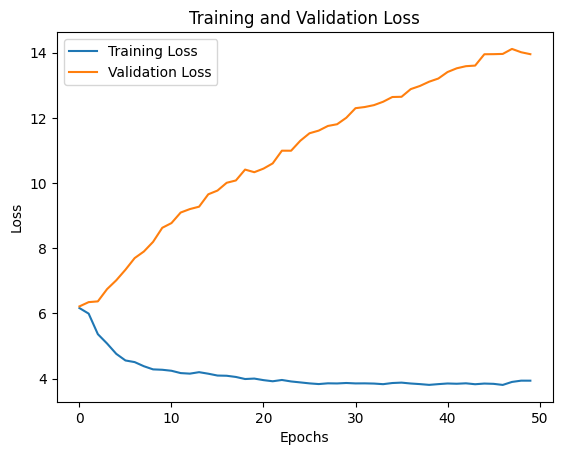

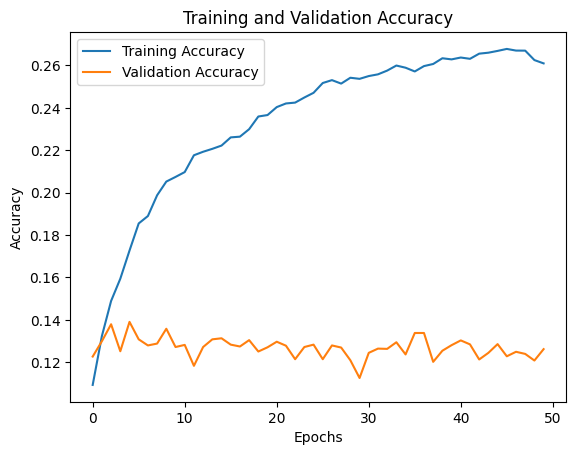

In [15]:
# Plot the training loss per epoch
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss per epoch
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  # x-axis represents epochs
plt.ylabel('Loss')    # y-axis represents loss value

# Add legend to differentiate training and validation curves
plt.legend()

# Display the loss plot
plt.show()

# =============================
# Plot Training and Validation Accuracy
# =============================
# Plot the training accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy per epoch
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')    # x-axis represents epochs
plt.ylabel('Accuracy')  # y-axis represents accuracy percentage

# Add legend to differentiate training and validation curves
plt.legend()

# Display the accuracy plot
plt.show()


## Inferences

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import HTML

In [17]:
# Function to predict top five probable next words
def predict_top_five_words(model, tokenizer, seed_text):
    """
    Input:
        model      : trained LSTM model
        tokenizer  : fitted Keras tokenizer
        seed_text  : string, starting words of the sentence
    Output:
        top_five_words : list of top 5 predicted next words
    """

    # Convert the seed text into a sequence of integers using the tokenizer
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the sequence to match the input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get predicted probabilities for all words in the vocabulary
    predicted = model.predict(token_list, verbose=0)

    # Get the indexes of the top 5 words with highest probability
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]

    # Convert the predicted indexes back to words using the tokenizer
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break  # Stop once the word for this index is found

    return top_five_words



In [18]:
# Function to display top 5 predictions in a new browser window
def predict_and_display_top_five_words(seed_text, model, tokenizer):
    """
    Input:
        seed_text : starting words for prediction
        model     : trained LSTM model
        tokenizer : fitted tokenizer
    Output:
        HTML object to open a new browser window with top 5 predicted sentences
    """

    # Get top 5 predicted words
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)

    # HTML heading for the app window
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"

    # Create an HTML unordered list of predicted sentences
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"

    # JavaScript code to open a new browser window and display predictions
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """

    # Return an IPython HTML object to render the JavaScript
    return HTML(javascript_code)


## Test the model

In [19]:
# Test the function

In [20]:
# Test 1:
seed_text = "She is my"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [21]:
# Test 2:
seed_text = "I have"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [22]:
# Test 3:
seed_text = "We love"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [23]:
# Test 4:
seed_text = "How are"
predict_and_display_top_five_words(seed_text, model, tokenizer)